In [1]:
import numpy as np
import sys
import pickle
import time

sys.path.append('../src/')

from angular_stress_heuristic import *
from utils import *
from interpolating_prior import interpolated_prior
from greedy_topology_optimization import monte_carlo_step
from iterative_geometry_solver import iterative_geometry_solver

In [2]:
np.random.seed(17)

#zero temperature:
T = 0
num_terminals = 100

# generate a random problem:
num_sources = np.random.randint(1, num_terminals)
num_sinks = num_terminals - num_sources
bot_problem_dict = generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                               max_length=1.)

coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

for al in np.linspace(0.0001,0.9999,8):
    bot_problem_dict["al"] = al
    al = bot_problem_dict["al"]

    print("\nstarted alpha=", al)

    time0 = time.time()

    # init star graph:
    topo = nx.Graph()
    for node in range(len(supply_arr) + len(demand_arr)):
        topo.add_edge(-1, node)


    # MC updating of topology:
    cost, coords_iter = iterative_geometry_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                             relative_improvement_threshold=1e-6, min_iterations=-1,
                                             max_iterations=1000,
                                             plot=False, title="", fov=None, save=False, save_name="img")
    keep_going = True
    iteration = 0
    sample_edge_list = list(topo.edges())
    while keep_going and iteration < 60000:
        iteration += 1
        topo, sample_edge_list, cost, coords_iter, accepted = monte_carlo_step(topo, sample_edge_list, cost,
                                                                               coords_iter, bot_problem_dict,
                                                                               temperature=T)
        # check if converged:
        if len(sample_edge_list) == 0:
            # this means that we have stuck with one topology for an entire run through.
            keep_going = False

    print(f"final result, after {iteration} iterations and {np.round(time.time() - time0, 2)} seconds.")

    # store the results in a pickle file:
    result_dict = {"bot_problem_dict":bot_problem_dict,
                   "topo":topo,
                   "iteration":iteration
                   }
    pkl_file_path = f"../results/output_files/varying_al_size{num_terminals}_al{np.round(al,2)}.pkl"
    output = open(pkl_file_path, 'wb')
    pickle.dump(result_dict, output)
    output.close()


started alpha= 0.0001
final result, after 1559 iterations and 85.96 seconds.

started alpha= 0.14292857142857143
final result, after 1498 iterations and 73.62 seconds.

started alpha= 0.2857571428571429
final result, after 1507 iterations and 98.23 seconds.

started alpha= 0.42858571428571435
final result, after 2285 iterations and 97.06 seconds.

started alpha= 0.5714142857142858
final result, after 1670 iterations and 164.87 seconds.

started alpha= 0.7142428571428572
final result, after 2803 iterations and 108.41 seconds.

started alpha= 0.8570714285714287
final result, after 3569 iterations and 183.4 seconds.

started alpha= 0.9999
final result, after 3654 iterations and 1793.13 seconds.


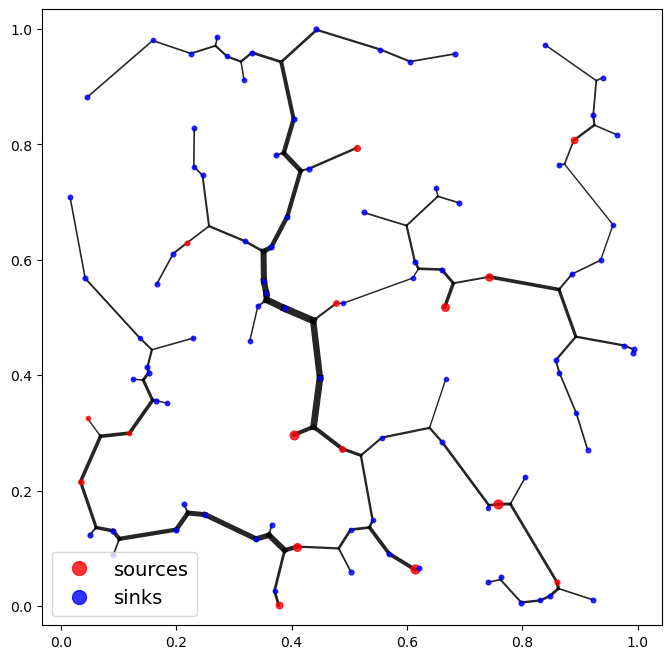

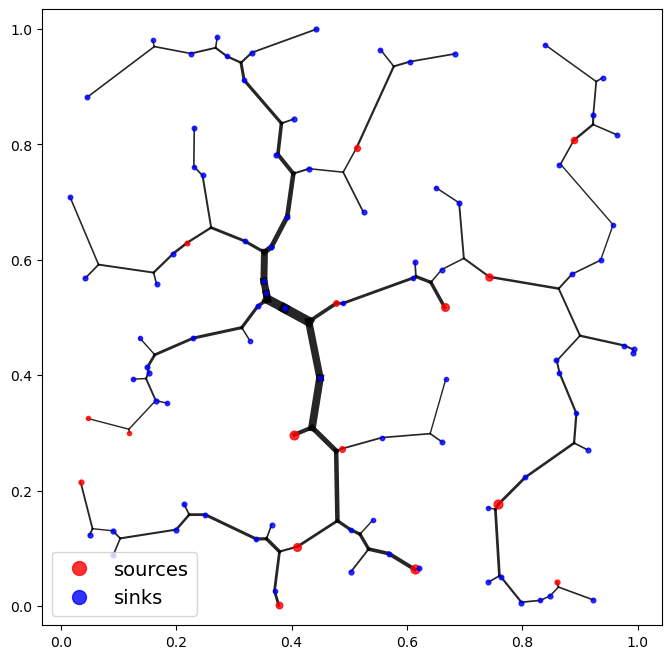

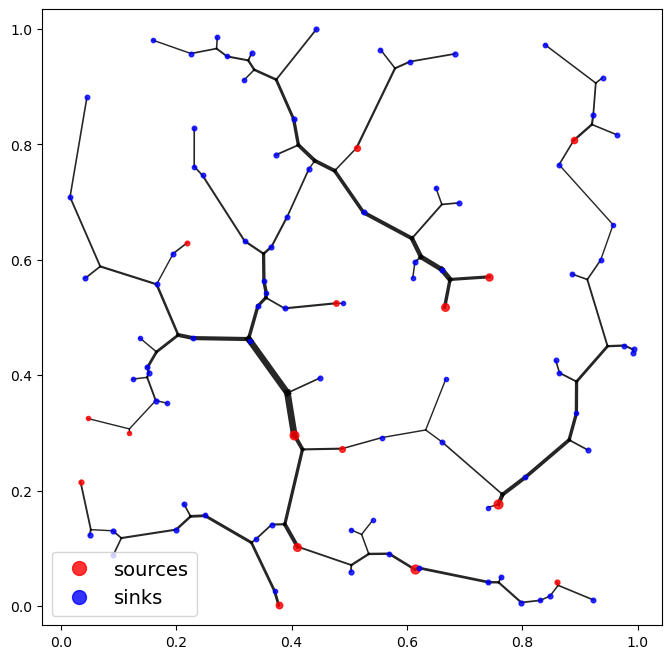

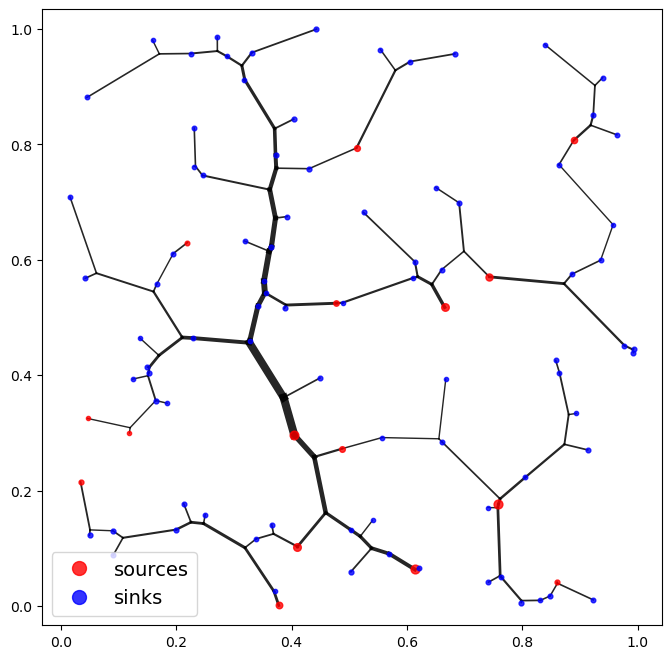

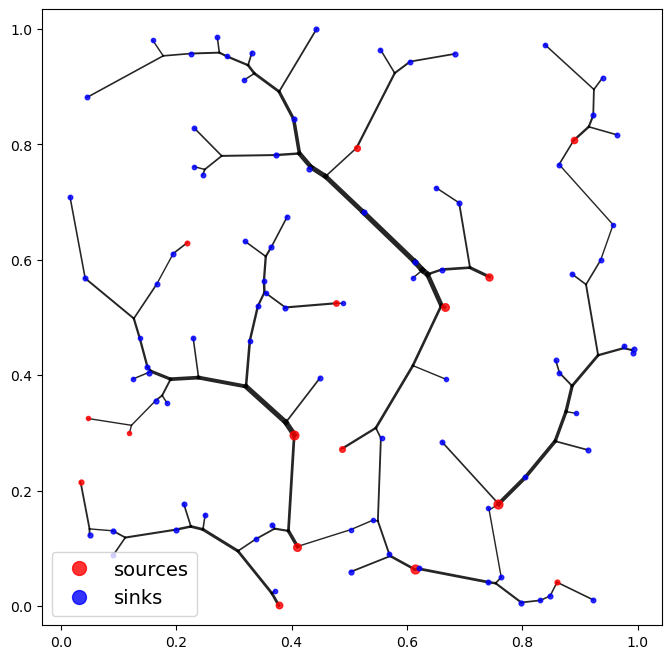

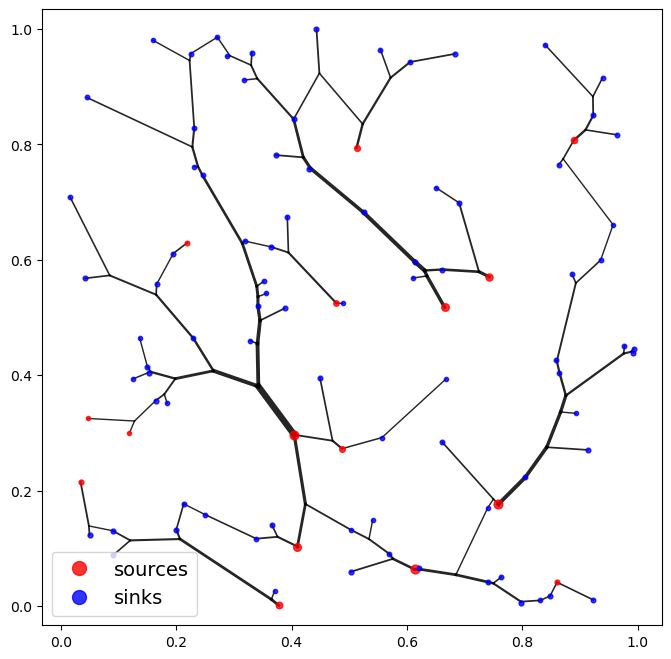

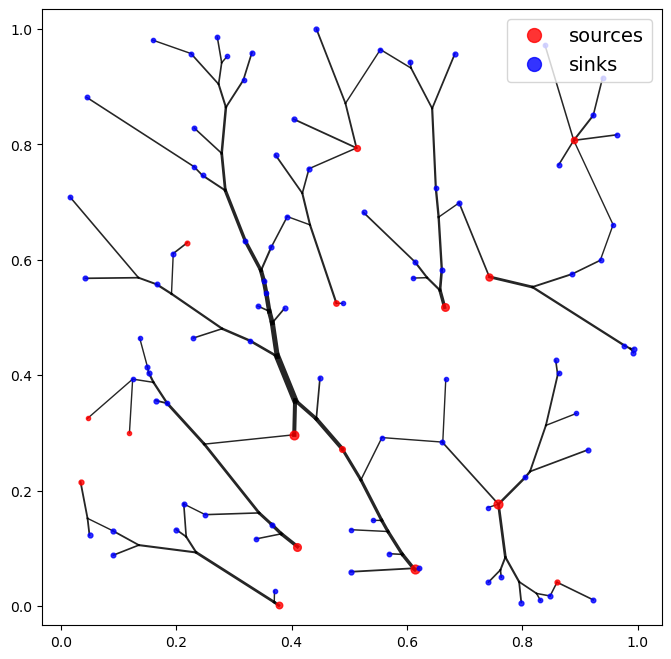

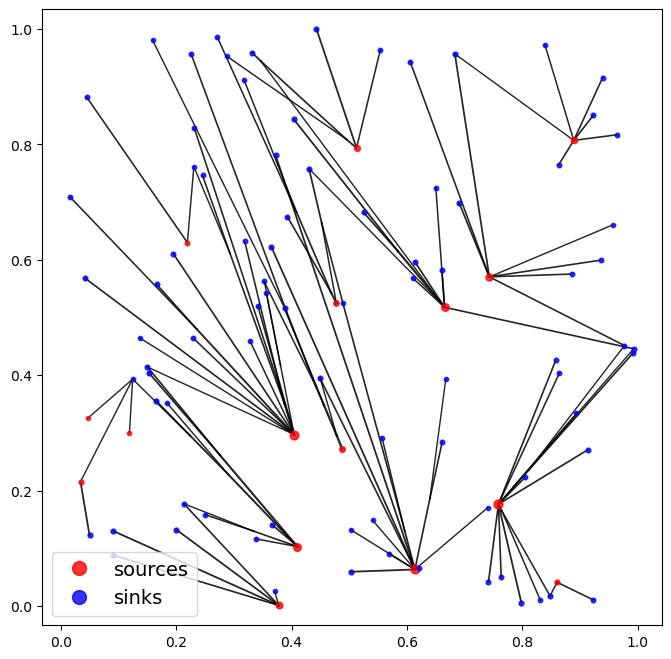

In [4]:
num_terminals = 100
for al in np.linspace(0.0001,0.9999,8):
    print("\nalpha =", al)
    
    # look at result:
    pkl_file_path = f"../results/output_files/varying_al_size{num_terminals}_al{np.round(al,2)}.pkl"
    pkl_file = open(pkl_file_path, 'rb')
    results_dict = pickle.load(pkl_file)
    pkl_file.close()
    
    bot_problem_dict = results_dict["bot_problem_dict"]
    topo = results_dict["topo"]

    al = bot_problem_dict["al"]
    coords_sources = bot_problem_dict["coords_sources"]
    coords_sinks = bot_problem_dict["coords_sinks"]
    supply_arr = bot_problem_dict["supply_arr"]
    demand_arr = bot_problem_dict["demand_arr"]

    iterative_geometry_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al,
                                             relative_improvement_threshold=0.5*1e-7, min_iterations=-1,
                                             max_iterations=2000,
                                             plot=True, title="", fov=None, save=False, save_name=f"vary_al{np.round(al,2)}")